In [5]:
import os
import time
import numpy as np
import json

# Download and install the Python COCO tools from https://github.com/waleedka/coco
# That's a fork from the original https://github.com/pdollar/coco with a bug
# fix for Python 3.
# I submitted a pull request https://github.com/cocodataset/cocoapi/pull/50
# If the PR is merged then use the original repo.
# Note: Edit PythonAPI/Makefile and replace "python" with "python3".
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils

import zipfile
import urllib.request
import shutil

from config import Config
import utils
import visualize
import model as modellib

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
DEFAULT_DATASET_YEAR = "2017"

############################################################
#  Configurations
############################################################


class CocoConfig(Config):
    """Configuration for training on MS COCO.
    Derives from the base Config class and overrides values specific
    to the COCO dataset.
    """
    # Give the configuration a recognizable name
    NAME = "coco"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Uncomment to train on 8 GPUs (default is 1)
    # GPU_COUNT = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 80  # COCO has 80 classes


############################################################
#  Dataset
############################################################

class CocoDataset(utils.Dataset):
    def load_coco(self, dataset_dir, subset, year=DEFAULT_DATASET_YEAR, class_ids=None,
                  class_map=None, return_coco=False, auto_download=False):
        """Load a subset of the COCO dataset.
        dataset_dir: The root directory of the COCO dataset.
        subset: What to load (train, val, minival, valminusminival)
        year: What dataset year to load (2014, 2017) as a string, not an integer
        class_ids: If provided, only loads images that have the given classes.
        class_map: TODO: Not implemented yet. Supports maping classes from
            different datasets to the same class ID.
        return_coco: If True, returns the COCO object.
        auto_download: Automatically download and unzip MS-COCO images and annotations
        """

        if auto_download is True:
            self.auto_download(dataset_dir, subset, year)

        coco = COCO("{}/annotations/instances_{}{}.json".format(dataset_dir, subset, year))
        if subset == "minival" or subset == "valminusminival":
            subset = "val"
        image_dir = "{}/{}{}".format(dataset_dir, subset, year)

        # Load all classes or a subset?
        if not class_ids:
            # All classes
            class_ids = sorted(coco.getCatIds())

        # All images or a subset?
        if class_ids:
            image_ids = []
            for id in class_ids:
                image_ids.extend(list(coco.getImgIds(catIds=[id])))
            # Remove duplicates
            image_ids = list(set(image_ids))
        else:
            # All images
            image_ids = list(coco.imgs.keys())

        # Add classes
        for i in class_ids:
            self.add_class("coco", i, coco.loadCats(i)[0]["name"])

        # Add images
        for i in image_ids:
            self.add_image(
                "coco", image_id=i,
                path=os.path.join(image_dir, coco.imgs[i]['file_name']),
                width=coco.imgs[i]["width"],
                height=coco.imgs[i]["height"],
                annotations=coco.loadAnns(coco.getAnnIds(
                    imgIds=[i], catIds=class_ids, iscrowd=None)))
        if return_coco:
            return coco

    def auto_download(self, dataDir, dataType, dataYear):
        """Download the COCO dataset/annotations if requested.
        dataDir: The root directory of the COCO dataset.
        dataType: What to load (train, val, minival, valminusminival)
        dataYear: What dataset year to load (2014, 2017) as a string, not an integer
        Note:
            For 2014, use "train", "val", "minival", or "valminusminival"
            For 2017, only "train" and "val" annotations are available
        """

        # Setup paths and file names
        if dataType == "minival" or dataType == "valminusminival":
            imgDir = "{}/{}{}".format(dataDir, "val", dataYear)
            imgZipFile = "{}/{}{}.zip".format(dataDir, "val", dataYear)
            imgURL = "http://images.cocodataset.org/zips/{}{}.zip".format("val", dataYear)
        else:
            imgDir = "{}/{}{}".format(dataDir, dataType, dataYear)
            imgZipFile = "{}/{}{}.zip".format(dataDir, dataType, dataYear)
            imgURL = "http://images.cocodataset.org/zips/{}{}.zip".format(dataType, dataYear)
        # print("Image paths:"); print(imgDir); print(imgZipFile); print(imgURL)

        # Create main folder if it doesn't exist yet
        if not os.path.exists(dataDir):
            os.makedirs(dataDir)

        # Download images if not available locally
        if not os.path.exists(imgDir):
            os.makedirs(imgDir)
            print("Downloading images to " + imgZipFile + " ...")
            with urllib.request.urlopen(imgURL) as resp, open(imgZipFile, 'wb') as out:
                shutil.copyfileobj(resp, out)
            print("... done downloading.")
            print("Unzipping " + imgZipFile)
            with zipfile.ZipFile(imgZipFile, "r") as zip_ref:
                zip_ref.extractall(dataDir)
            print("... done unzipping")
        print("Will use images in " + imgDir)

        # Setup annotations data paths
        annDir = "{}/annotations".format(dataDir)
        if dataType == "minival":
            annZipFile = "{}/instances_minival2014.json.zip".format(dataDir)
            annFile = "{}/instances_minival2014.json".format(annDir)
            annURL = "https://dl.dropboxusercontent.com/s/o43o90bna78omob/instances_minival2014.json.zip?dl=0"
            unZipDir = annDir
        elif dataType == "valminusminival":
            annZipFile = "{}/instances_valminusminival2014.json.zip".format(dataDir)
            annFile = "{}/instances_valminusminival2014.json".format(annDir)
            annURL = "https://dl.dropboxusercontent.com/s/s3tw5zcg7395368/instances_valminusminival2014.json.zip?dl=0"
            unZipDir = annDir
        else:
            annZipFile = "{}/annotations_trainval{}.zip".format(dataDir, dataYear)
            annFile = "{}/instances_{}{}.json".format(annDir, dataType, dataYear)
            annURL = "http://images.cocodataset.org/annotations/annotations_trainval{}.zip".format(dataYear)
            unZipDir = dataDir
        # print("Annotations paths:"); print(annDir); print(annFile); print(annZipFile); print(annURL)

        # Download annotations if not available locally
        if not os.path.exists(annDir):
            os.makedirs(annDir)
        if not os.path.exists(annFile):
            if not os.path.exists(annZipFile):
                print("Downloading zipped annotations to " + annZipFile + " ...")
                with urllib.request.urlopen(annURL) as resp, open(annZipFile, 'wb') as out:
                    shutil.copyfileobj(resp, out)
                print("... done downloading.")
            print("Unzipping " + annZipFile)
            with zipfile.ZipFile(annZipFile, "r") as zip_ref:
                zip_ref.extractall(unZipDir)
            print("... done unzipping")
        print("Will use annotations in " + annFile)

    def load_mask(self, image_id):
        """Load instance masks for the given image.
        Different datasets use different ways to store masks. This
        function converts the different mask format to one format
        in the form of a bitmap [height, width, instances].
        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a COCO image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "coco":
            return super(CocoDataset, self).load_mask(image_id)

        instance_masks = []
        class_ids = []
        annotations = self.image_info[image_id]["annotations"]         
        # Build mask of shape [height, width, instance_count] and list
        # of class IDs that correspond to each channel of the mask.
        for annotation in annotations:
            class_id = self.map_source_class_id(
                "coco.{}".format(annotation['category_id']))
            if class_id:
                m = self.annToMask(annotation, image_info["height"],
                                   image_info["width"])
                # Some objects are so small that they're less than 1 pixel area
                # and end up rounded out. Skip those objects.
                if m.max() < 1:
                    continue
                # Is it a crowd? If so, use a negative class ID.
                if annotation['iscrowd']:
                    # Use negative class ID for crowds
                    class_id *= -1
                    # For crowd masks, annToMask() sometimes returns a mask
                    # smaller than the given dimensions. If so, resize it.
                    if m.shape[0] != image_info["height"] or m.shape[1] != image_info["width"]:
                        m = np.ones([image_info["height"], image_info["width"]], dtype=bool)
                instance_masks.append(m)
                class_ids.append(class_id)

        # Pack instance masks into an array
        if class_ids:
            mask = np.stack(instance_masks, axis=2)
            class_ids = np.array(class_ids, dtype=np.int32)
            return mask, class_ids
        else:
            # Call super class to return an empty mask
            return super(CocoDataset, self).load_mask(image_id)

    def image_reference(self, image_id):
        """Return a link to the image in the COCO Website."""
        info = self.image_info[image_id]
        if info["source"] == "coco":
            return "http://cocodataset.org/#explore?id={}".format(info["id"])
        else:
            super(CocoDataset, self).image_reference(self, image_id)

    # The following two functions are from pycocotools with a few changes.

    def annToRLE(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE to RLE.
        :return: binary mask (numpy 2D array)
        """
        segm = ann['segmentation'] 
        print(segm)
        print("===New Line===")
        if isinstance(segm, list):
            # polygon -- a single object might consist of multiple parts
            # we merge all parts into one mask rle code
            rles = maskUtils.frPyObjects(segm, height, width)
            rle = maskUtils.merge(rles)
        elif isinstance(segm['counts'], list):
            # uncompressed RLE
            rle = maskUtils.frPyObjects(segm, height, width)
        else:
            # rle
            rle = ann['segmentation']
        return rle

    def annToMask(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
        :return: binary mask (numpy 2D array)
        """
        rle = self.annToRLE(ann, height, width)
        m = maskUtils.decode(rle)
        return m


############################################################
#  COCO Evaluation
############################################################

def build_coco_results(dataset, image_ids, rois, class_ids, scores, masks):
    """Arrange resutls to match COCO specs in http://cocodataset.org/#format
    """
    # If no results, return an empty list
    if rois is None:
        return []

    results = []
    for image_id in image_ids:
        # Loop through detections
        for i in range(rois.shape[0]):
            class_id = class_ids[i]
            score = scores[i]
            bbox = np.around(rois[i], 1)
            mask = masks[:, :, i]

            result = {
                "image_id": image_id,
                "category_id": dataset.get_source_class_id(class_id, "coco"),
                "bbox": [bbox[1], bbox[0], bbox[3] - bbox[1], bbox[2] - bbox[0]],
                "score": score,
                "segmentation": maskUtils.encode(np.asfortranarray(mask))
            }
            results.append(result)
    return results


def evaluate_coco(model, dataset, coco, eval_type="bbox", limit=0, image_ids=None):
    """Runs official COCO evaluation.
    dataset: A Dataset object with valiadtion data
    eval_type: "bbox" or "segm" for bounding box or segmentation evaluation
    limit: if not 0, it's the number of images to use for evaluation
    """
    # Pick COCO images from the dataset
    image_ids = image_ids or dataset.image_ids

    # Limit to a subset
    if limit:
        image_ids = image_ids[:limit]

    # Get corresponding COCO image IDs.
    coco_image_ids = [dataset.image_info[id]["id"] for id in image_ids]

    t_prediction = 0
    t_start = time.time()

    results = []
    for i, image_id in enumerate(image_ids):
        # Load image
        image = dataset.load_image(image_id)

        # Run detection
        t = time.time()
        r = model.detect([image], verbose=0)[0]
        t_prediction += (time.time() - t)

        # Convert results to COCO format
        image_results = build_coco_results(dataset, coco_image_ids[i:i + 1],
                                           r["rois"], r["class_ids"],
                                           r["scores"], r["masks"])
        results.extend(image_results)

    # Load results. This modifies results with additional attributes.
    coco_results = coco.loadRes(results)

    # Evaluate
    cocoEval = COCOeval(coco, coco_results, eval_type)
    cocoEval.params.imgIds = coco_image_ids
    cocoEval.evaluate()
    cocoEval.accumulate()
    cocoEval.summarize()

    print("Prediction time: {}. Average {}/image".format(
        t_prediction, t_prediction / len(image_ids)))
    print("Total time: ", time.time() - t_start)

# Root directory of the project
ROOT_DIR = os.getcwd()



COCO_DIR = os.path.join(ROOT_DIR, "coco")


config = CocoConfig()
config.display()

dataset_train = CocoDataset()
dataset_train.load_coco(COCO_DIR, "train", "2017")
dataset_train.prepare()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           coco
NUM_CLASSES                    81
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINI

[[227.41, 81.56, 312.81, 91.16, 404.93, 118.98, 451.95, 138.18, 437.56, 331.04, 413.57, 344.48, 397.25, 339.68, 403.01, 324.33, 419.32, 324.33, 419.32, 255.24, 389.58, 240.85, 361.75, 216.86, 355.99, 272.51, 337.76, 284.03, 360.79, 349.28, 298.42, 349.28, 300.34, 299.38, 286.91, 258.12, 266.76, 254.28, 248.52, 309.93, 249.48, 355.99, 224.53, 354.07, 220.7, 251.4, 237.01, 185.19, 243.73, 130.5]]
===New Line===
[[180.8, 300.05, 179.84, 314.48, 176.95, 342.37, 176.95, 354.87, 171.18, 363.53, 167.34, 369.3, 153.87, 372.18, 132.72, 373.14, 126.95, 370.26, 106.75, 367.37, 97.13, 366.41, 94.25, 364.49, 92.32, 306.79, 77.9, 237.54, 72.13, 218.31, 69.24, 196.19, 60.59, 134.64, 67.32, 100.98, 74.05, 75.01, 91.36, 54.82, 105.79, 41.35, 117.33, 27.89, 127.91, 21.16, 146.18, 18.27, 167.34, 19.23, 181.76, 28.85, 201.0, 46.16, 218.31, 63.47, 226.96, 74.05, 233.7, 92.32, 234.66, 109.64, 239.47, 127.91, 240.43, 148.1, 235.62, 167.34, 232.73, 196.19, 230.81, 214.46, 226.96, 234.66, 225.04, 251.01, 217.3

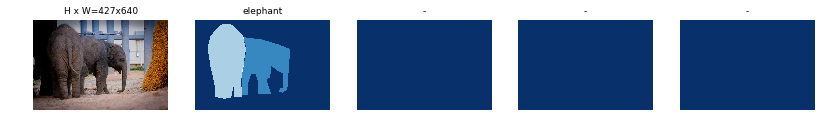

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 1)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)